=### Task 4: Nested cross validation
#### **Objective**
In this lab, you will implement missing parts of a `NestedCrossValidator` class. This class performs nested cross-validation for hyperparameter tuning and model evaluation.

#### **Overview**
Nested cross-validation consists of two levels:
1. **Outer Cross-Validation**: Splits the dataset into training and test sets to evaluate model performance.
2. **Inner Cross-Validation**: Further splits the training data to perform hyperparameter tuning.

Your task is to implement the missing parts (marked as `TODO`) in the given code. Note that the

---

#### **SubTasks**

##### **SubTask 1: Implement Manual Fold Creation**
- **Function to complete**: `_create_folds(self, X, y, n_splits)`
- **Purpose**: Manually create train-test folds for cross-validation.
- **Implementation details**:
  - Create an array of indices `0` to `len(X)-1`.
  - Shuffle the indices.
  - Split them into `n_splits` folds.
  - Return a list of `(train_indices, test_indices)`.
- **Note**: Don't discard data samples! If the number of samples is not divisible by *k*, distribute the remaining sample among the folds.

---

##### **SubTask 2: Implement Nested Cross-Validation**
- **Function to complete**: `fit(self, X, y)`
- **Purpose**: Perform nested cross-validation for model selection and evaluation.
- **Implementation details**:
  - Create outer folds using `_create_folds()`.
  - Iterate through outer folds:
    - Split data into outer train/test sets.
    - Initialize best parameters and best score.
    - Create inner folds from outer training set.
    - Iterate over hyperparameter combinations:
      - Train model using inner train sets.
      - Evaluate model using inner validation sets.
      - Store the best hyperparameter combination.
    - Train the final model on outer training data using the best parameters.
    - Evaluate the model on the outer test set.
  - Return list of outer fold accuracies and overall mean accuracy.



In [13]:
import numpy as np
from sklearn.metrics import accuracy_score
from itertools import product

class NestedCrossValidator:
    def __init__(self, model_class, param_grid, outer_splits=5, inner_splits=3, random_seed=None):
        """
        Initialize the nested cross-validator.

        :param model_class: The model class to be used (e.g., SVC, RandomForestClassifier).
        :param param_grid: Dictionary of hyperparameters and their values to search.
        :param outer_splits: Number of splits for the outer cross-validation.
        :param inner_splits: Number of splits for the inner cross-validation.
        :param random_seed: Random seed for reproducibility.
        """
        self.model_class = model_class
        self.param_grid = param_grid
        self.outer_splits = outer_splits
        self.inner_splits = inner_splits
        self.random_seed = random_seed

    def _create_folds(self, X, y, n_splits):

        np.random.seed(self.random_seed)  # DO NOT DELETE THIS LINE
        total_indices = np.arange(len(X))

    # Step 1: Shuffle the indices.
        np.random.shuffle(total_indices)

    # Step 2: Calculate the size for each fold split
        fold_sizes = [len(total_indices) // n_splits] * n_splits
        for i in range(len(total_indices) % n_splits):
            fold_sizes[i] += 1
        folds = []
        start = 0

        for i in range(n_splits):
        # Step 3: Split the shuffled indices into n_splits folds.
            fold_size = fold_sizes[i]
            test_indices = total_indices[start:start + fold_size]
            train_indices = np.concatenate(
              (total_indices[:start], total_indices[start + fold_size:])
            )
            folds.append((train_indices, test_indices))
            start += fold_size

        return folds


    def fit(self, X, y):
        """
        Perform nested cross-validation to evaluate model performance.

        :param X: Feature matrix.
        :param y: Target vector.
        :return: List of outer fold accuracies and mean accuracy.
        """
        # TODO: implement this function
        # Step 1: Create outer folds using _create_folds().
        outer_folds = self._create_folds(X, y, self.outer_splits)
        # Step 2: Initialize a list to store outer fold results.
        outer_results = []

        # Step 3: Loop through each outer fold.
        for outer_idx, (train_idx, test_idx) in enumerate(outer_folds):
            # Step 4: Split data into outer train/test sets.
            X_outer_train , y_outer_train = X[train_idx], y[train_idx]
            X_outer_test , y_outer_test = X[test_idx], y[test_idx]

            # Inner loop for hyperparameter tuning
            # Step 5: Initialize best parameters and best score.
            best_params = None
            best_score = -np.inf

            # Step 6: Create inner folds from outer training data.
            inner_folds = self._create_folds(X_outer_train, y_outer_train, self.inner_splits)

            # Step 7: Iterate over hyperparameter combinations.
            for param_combination in product(*self.param_grid.values()):
                params = dict(zip(self.param_grid.keys(), param_combination))
                inner_scores = []

                # Step 8: Train model using inner train sets and evaluate using validation sets.
                for inner_train_idx, inner_val_idx in inner_folds:
                    # Split data into inner train/test sets

                    X_inner_train, y_inner_train = X_outer_train[inner_train_idx], y_outer_train[inner_train_idx]

                    X_inner_val, y_inner_val = X_outer_train[inner_val_idx], y_outer_train[inner_val_idx]

                    # Train model with the current parameters
                    model = self.model_class(**params)
                    model.fit(X_inner_train, y_inner_train)

                    # Evaluate on validation set and update inner_scores
                    y_val_pred = model.predict(X_inner_val)
                    acc = accuracy_score(y_inner_val, y_val_pred)
                    inner_scores.append(acc)

                # Step 9: Select the best hyperparameter combination.
                # Compute mean score and update best parameters
                mean_outer_acc = np.mean(inner_scores)
                if mean_outer_acc > best_score:
                    best_score = mean_outer_acc
                    best_params = params

            # Step 10: Train the final model on outer training data using best parameters.
            final_model = self.model_class(**best_params)
            final_model.fit(X_outer_train, y_outer_train)

            # Step 11: Evaluate the final model on outer test set and store the result.
            y_test_pred = final_model.predict(X_outer_test)
            outer_accuracy = accuracy_score(y_outer_test,y_test_pred)

            outer_results.append((outer_accuracy))
            print(f"Outer Fold {outer_idx + 1} - Best Params: {best_params}, Accuracy: {outer_accuracy:.4f}")

        mean_outer_accuracy = np.mean(outer_results)
        print(f"\nOverall Accuracy from Nested Cross-Validation: {mean_outer_accuracy:.4f}")
        # Step 12: Return list of outer fold accuracies and overall mean accuracy.
        return outer_results, mean_outer_accuracy

Lets test if it works

Outer Fold 1 - Best Params: {'n_estimators': 100, 'max_depth': 20}, Accuracy: 0.9737
Outer Fold 2 - Best Params: {'n_estimators': 100, 'max_depth': 20}, Accuracy: 0.9561
Outer Fold 3 - Best Params: {'n_estimators': 100, 'max_depth': 50}, Accuracy: 0.9211
Outer Fold 4 - Best Params: {'n_estimators': 10, 'max_depth': 50}, Accuracy: 0.9474
Outer Fold 5 - Best Params: {'n_estimators': 100, 'max_depth': 50}, Accuracy: 0.9823

Overall Accuracy from Nested Cross-Validation: 0.9561


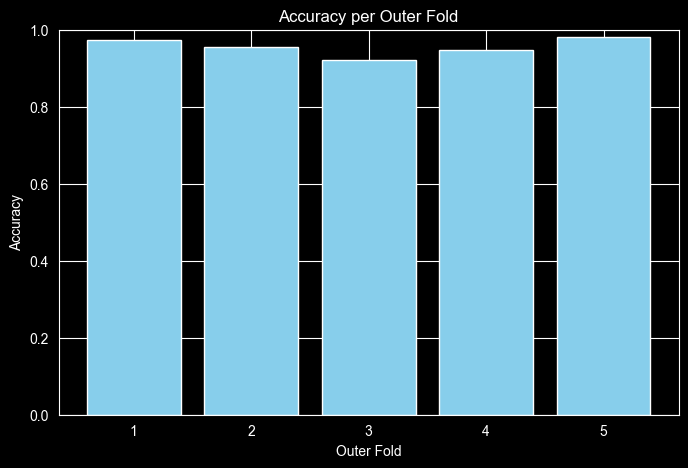

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Define hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': [3, 5, 10, 20, 50]
}

# Initialize and run nested cross-validation
nested_cv = NestedCrossValidator(model_class=RandomForestClassifier, param_grid=param_grid, outer_splits=5, inner_splits=3, random_seed=0)
outer_results, meanaccuracy = nested_cv.fit(X, y)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(outer_results) + 1), outer_results, color='skyblue')
plt.xlabel('Outer Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Outer Fold')
plt.ylim(0, 1.0)
plt.show()